In [116]:
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

The Three Coin Problem converted to Four Coins

We generate our data set with initial values $\lambda$, $p_1$, and $p_2$. Below, I did each trial having four coin flips rather than three coin flips. We'll see why in a bit.

In [117]:
l_actual = 0.7 
p1_actual = 0.9
p2_actual = 0.1
trials = 100
data = []
num_coins = 4

def gen_trial(p):
    trial = []
    for i in xrange(num_coins): #range given by the number of flips per trial, in this case 4
        if random.random() < p: #random.random() gives values between 0 and 1 which is useful given l,p1,and p2
            trial.append(1)
        else:
            trial.append(0)
    return trial

#1 is heads
#0 is tails
for i in xrange(trials):
    if random.random() < l_actual:
        datum = gen_trial(p1_actual)
    else:
        datum = gen_trial(p2_actual)
    data.append(datum)

We find $\mu$ and iterate to get the $\lambda$, $p_1$, and $p_2$ values that converge to the values that have the highest probability of reproducing the data set generated previously. 

We extend to have four coins per trial because it gives only one value per parameter, as opposed to 3 coins. 

The plots below show the values for $p_1$ and $p_2$ and then $\lambda$ with $100$ random guesses respectively.

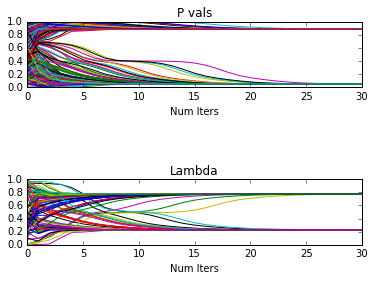

In [118]:
def get_u(data,l, p1, p2):
    u = []
    for datum in data:
        n = len(datum)
        heads = sum(datum)
        p_l1 = l * p1**heads * (1 - p1)**(n - heads)
        p_l2 = (1 - l) * p2 **heads * (1 - p2)**(n - heads)
        u_i = p_l1 / (p_l1 + p_l2)
        u.append(u_i)
    return u

def solve(l, p1, p2, num_iters):
    iteration_values = [(l, p1, p2)]
    for j in xrange(num_iters):
        u = get_u(data, l, p1, p2)
        l = sum(u)/len(u)
        p1 = sum([u[i]*sum(data[i])/4. for i in xrange(len(data))])/sum(u)
        p2 = sum([(1-u[i])*sum(data[i])/4. for i in xrange(len(data))])/(len(u)-sum(u))
        iteration_values.append((l, p1, p2))
    return iteration_values

for j in xrange(100):
    l, p1, p2 = (random.random(), random.random(), random.random())
    iter_vals = solve(l, p1, p2, 30)
    l_vals, p1_vals, p2_vals = zip(*iter_vals)
    
    plt.subplot(3, 1, 1)
    plt.title("P vals")
    plt.xlabel("Num Iters")
    plt.plot(p1_vals)
    plt.plot(p2_vals)
    
    plt.subplot(3, 1, 3)
    plt.title("Lambda")
    plt.xlabel("Num Iters")
    plt.plot(l_vals)

plt.show()


GMM

Couldn't get it quite working, but it's not far off. First I'll generate data with some initial guesses and then we'll use GMM. See the plot at the end for comparision of the acutal vs. the iterated.


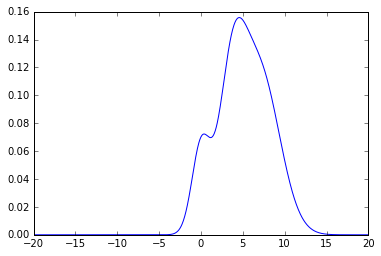

In [119]:
mu1 = 7.
mu2 = 3.7
mu3 = 0.
sigma1 = 2.4 
sigma2 = 1.6
sigma3 = 1.1
lam1 = .7
lam2 = .4
lam3 = .17
N = 500 #num samples
draws = np.zeros(N)

X = np.linspace(-20, 20, 1000)
Y1 = np.array([(lam1/(sigma1*np.sqrt(2*np.pi)))*np.exp(-(x-mu1)**2/(2*sigma1**2)) for x in X])
Y2 = np.array([(lam2/(sigma2*np.sqrt(2*np.pi)))*np.exp(-(x-mu2)**2/(2*sigma2**2)) for x in X])
Y3 = np.array([(lam3/(sigma3*np.sqrt(2*np.pi)))*np.exp(-(x-mu3)**2/(2*sigma3**2)) for x in X])

plt.plot(X, Y1 + Y2 + Y3)
plt.show()

for i in xrange(N):
    r = np.random.rand()
    if r < lam1:
        draws[i] = np.random.normal(mu1, sigma1)
    elif r < lam1 + lam2:
        draws[i] = np.random.normal(mu2, sigma2)
    else:
        draws[i] = np.random.normal(mu3, sigma3)

In [120]:
def solver(guess, niters = 100):
    w = np.zeros((3, N))
    for i in xrange(niters):
        if guess[0][2]**2 > .0001 and guess[1][2]**2 > .0001 and guess[2][2]**2 > .0001:
            for x in xrange(N):
                w1 = guess[0][0]*np.exp((-(draws[x]-guess[0][1])**2)/(2*guess[0][2]**2))/(np.sqrt(2*np.pi)*guess[0][2])
                w2 = guess[1][0]*np.exp((-(draws[x]-guess[1][1])**2)/(2*guess[1][2]**2))/(np.sqrt(2*np.pi)*guess[1][2])
                w3 = guess[2][0]*np.exp((-(draws[x]-guess[2][1])**2)/(2*guess[2][2]**2))/(np.sqrt(2*np.pi)*guess[2][2])
                s = sum([w1, w2, w3])
                w1 /= s
                w2 /= s 
                w3 /= s
                w[0, x] = w1
                w[1, x] = w2
                w[2, x] = w3
            guess[0][0] = np.mean(w[0])
            guess[1][0] = np.mean(w[1])
            guess[2][0] = np.mean(w[2])
            if sum(w[0])**2 > .0001 and sum(w[1])**2 > .0001 and sum(w[2])**2 > .0001:
                guess[0][1] = sum(draws*w[0])/sum(w[0])
                guess[1][1] = sum(draws*w[1])/sum(w[1])
                guess[2][1] = sum(draws*w[2])/sum(w[2])
                guess[0][2] = np.sqrt(sum(abs(draws-guess[0][1])*w[0])/sum(w[0]))
                guess[1][2] = np.sqrt(sum(abs(draws-guess[1][1])*w[1])/sum(w[1]))
                guess[2][2] = np.sqrt(sum(abs(draws-guess[2][1])*w[2])/sum(w[2]))
    return guess

guess = np.random.rand(3, 3)
sol = solver(guess)
sol[:, 2] = sol[:, 2]**2
print np.round(sol, 2)

[[ 0.4   3.56  0.94]
 [ 0.36  6.64  0.8 ]
 [ 0.23  9.58  0.98]]


And we compare this to the acutal values, The only value that is off is 3rd row 2nd column:

\begin{bmatrix} 
                  .6 & 6 & 2 \\
                 .4 & 3.& 1.5 \\
                 .2 & 0 & 1 
                 \end{bmatrix}
                 
Now we will compare the actual values to the iterated guess. 

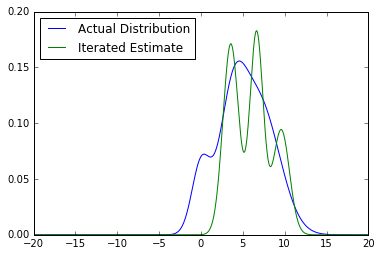

In [121]:

y1 = np.array([(sol[0,0]/(sol[0,2]*np.sqrt(2*np.pi)))*np.exp(-(x-sol[0,1])**2/(2*sol[0,2]**2)) for x in X])
y2 = np.array([(sol[1,0]/(sol[1,2]*np.sqrt(2*np.pi)))*np.exp(-(x-sol[1,1])**2/(2*sol[1,2]**2)) for x in X])
y3 = np.array([(sol[2,0]/(sol[2,2]*np.sqrt(2*np.pi)))*np.exp(-(x-sol[2,1])**2/(2*sol[2,2]**2)) for x in X])

plt.plot(X, Y1 + Y2 + Y3, label = "Actual Distribution")
plt.plot(X, y1 + y2 + y3, label = "Iterated Estimate")
plt.legend(loc = "best")
plt.show()